In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as ss

In [2]:
data_main = pd.read_csv('./odi_score.csv')
data = data_main.drop('Unnamed: 0', axis=1)
#data.to_csv('./odi_score.csv')
data.reset_index(inplace=True)

In [3]:
unique_bowl_values = list(data['bowling_team'].unique())
unique_bat_values = list(data['batting_team'].unique())

unique_team = list(zip(unique_bat_values, unique_bowl_values))
print(unique_team)

[('Australia', 'Pakistan'), ('Pakistan', 'Australia'), ('New Zealand', 'New Zealand'), ('South Africa', 'Bangladesh'), ('Bangladesh', 'South Africa'), ('India', 'England'), ('England', 'Sri Lanka'), ('Sri Lanka', 'India'), ('West Indies', 'West Indies'), ('Afghanistan', 'Afghanistan')]


In [4]:
total_na_values = data.isnull().sum()
null_values = (total_na_values/data.isnull().count())
missing_data = pd.concat([total_na_values, null_values], axis=1, keys=['Total', 'In %'])
missing_cols = (missing_data[missing_data.Total > 0]).index
print(missing_cols)

Index(['last_five'], dtype='object')


In [5]:
data.fillna(0, inplace=True)
data.drop(['index', 'match_id'], axis=1, inplace=True)

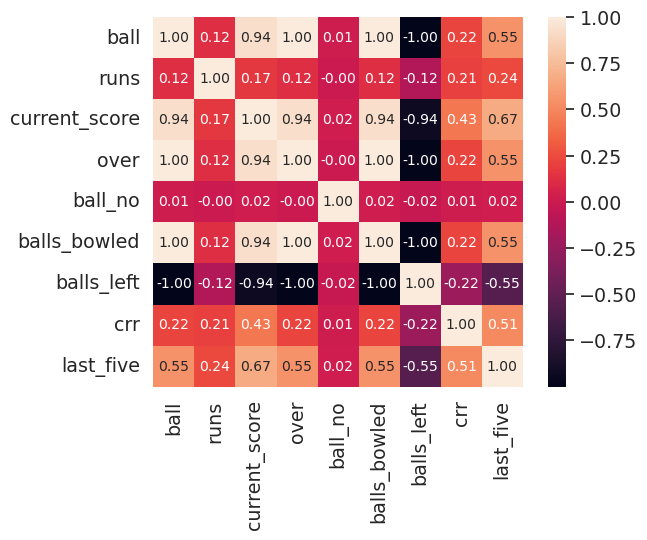

In [6]:
def generate_heatmap(df, target_col):
    num_cols = [col for col in data if data[col].dtype in ['int64', 'float64']]
    corr_mat = df[num_cols].corr()
    cols = corr_mat[target_col].index
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25);
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    
generate_heatmap(data, 'runs')

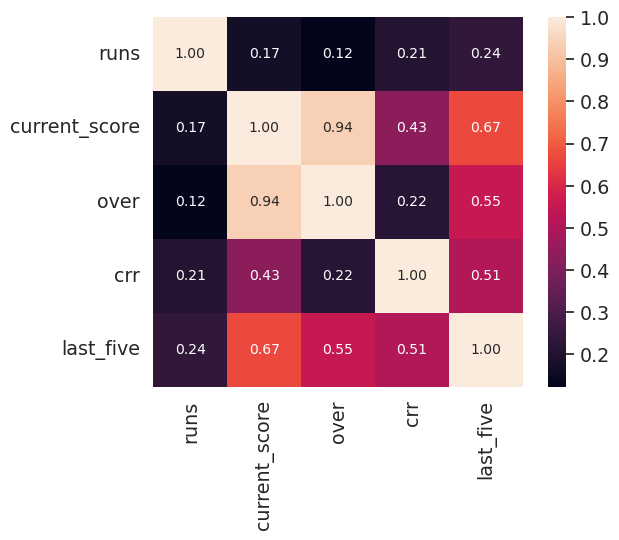

In [7]:
data = data.drop(['ball', 'balls_bowled', 'ball_no', 'balls_left'], axis=1)
generate_heatmap(data, 'runs')

/home/alp/anaconda3/envs/tf/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


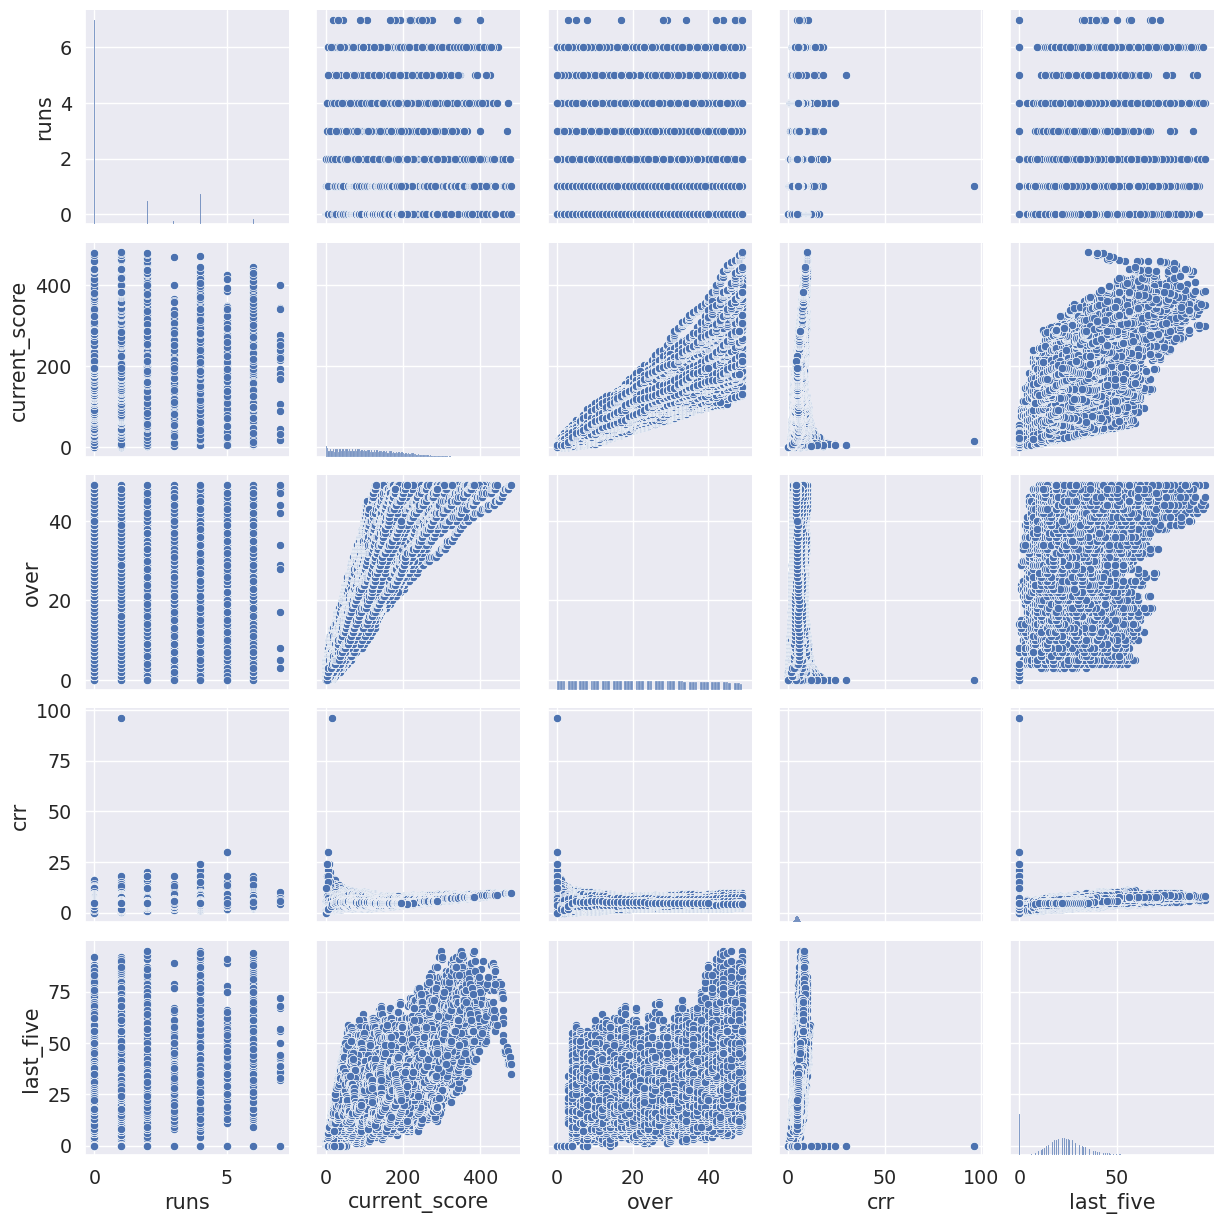

In [8]:
sns.pairplot(data)

In [9]:
# #data.to_csv('clean_data.csv')
# def get_over(df=data, row_idx=0, over=True):
#     row = df.loc[row_idx]
#     if over:
#         return row['over']
#     else:
#         return row
#         
# rows = data.shape[0]
# last_ball_count = 6 
# reduced_data = pd.DataFrame(data.columns)
# reduced_data_idx = 0
# curr = get_over(data, last_ball_count) 
# next_ = get_over(data, last_ball_count+1)
# 
# while last_ball_count < rows:
#     if curr != next_:
#         last_ball_count = last_ball_count + 1
#     else:
#         last_ball_count = last_ball_count + 6 
# 
#     curr = get_over(data, last_ball_count-1)
#     next_ = get_over(data, last_ball_count)
#     if reduced_data_idx > rows:
#         reduced_data_idx = rows-1
#     reduced_data.loc[reduced_data_idx] = get_over(data, last_ball_count-1, False)
#     reduced_data_idx = reduced_data_idx+1
#     print('running')

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error

num_cols = [col for col in data if data[col].dtype in ['int64', 'float64']]
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values='None', fill_value='None')),
    ('ohe', ohe)
])

transform_col = ColumnTransformer(transformers=[
    cat_pipe
])

model = RandomForestRegressor() 
pipe = Pipeline(steps=[
    ('transformer', transform_col),
    ('model', model)
])

In [29]:
from sklearn.linear_model import SGDOneClassSVM

svm = SGDOneClassSVM(nu=0.001)
data_num = data[num_cols]
yhat = svm.fit_predict(data_num)
print(np.count_nonzero(yhat == -1))
mask = yhat != -1
data_SVM = data_num.loc[mask, :].reset_index(drop=True)
X_SVM, Y_SVM = data_SVM.drop('current_score', axis = 1), data_SVM['current_score']

score = cross_val_score(
    model, X_SVM, Y_SVM, cv=10, scoring='neg_mean_squared_error'
)

print(score.mean(), score.std())

2088
-1.2496294079650923 1.876078443422626


In [30]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=0)
yhat = iso.fit_predict(data_num)
print(np.count_nonzero(yhat == -1))
mask = yhat != -1
data_ISO = data_num.loc[mask, :].reset_index(drop=True)
X_ISO, Y_ISO = data_ISO.drop('current_score', axis = 1), data_ISO['current_score']

score = cross_val_score(model, X_ISO, Y_ISO, cv=10, scoring='neg_mean_squared_error')
print(score.mean(), score.std())

75101
-0.35950880707587096 0.05295787028429251


In [35]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
yhat = lof.fit_predict(data_num)
print(np.count_nonzero(yhat == -1))
mask = yhat != -1
data_LOF = data_num.loc[mask, :].reset_index(drop=True)
X_LOF, Y_LOF= data_LOF.drop('current_score', axis = 1), data_LOF['current_score']

score = cross_val_score(model, X_LOF, Y_LOF, cv=10, scoring='neg_mean_squared_error')
print(score.mean(), score.std())

4907


KeyboardInterrupt: 

In [11]:
X = data[num_cols]

X_train = X.sample(frac=0.7, axis=0)
X_eval = X.drop(X_train.index, axis=0)

Y_train = X_train['current_score']
X_train.drop(['current_score'], axis=1, inplace=True)

y_eval = X_eval['current_score']
X_eval.drop(['current_score'], axis=1, inplace=True)
print(X_train.shape, X_eval.shape)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.8)
hist = model.fit(x_train, y_train)
pred = model.predict(x_test)

mse = mean_squared_error(y_test, pred)
rmse = mse**.5
print(mse)
print(rmse)


(205937, 4) (88259, 4)
0.6399883312460182
0.7999927069955189


In [12]:
X = data.copy()
categorical_cols = [col for col in X.columns if X[col].dtype in ['object']]
transform = ohe.fit_transform(X[categorical_cols])
#transform = transform.toarray()
transform = pd.DataFrame(transform, columns=ohe.get_feature_names_out())
transform.head()
X.drop(categorical_cols, axis=1, inplace=True)
X = pd.concat([X, transform], axis=1)
X.head()

,runs,current_score,over,crr,last_five,batting_team_Australia,batting_team_Bangladesh,batting_team_England,batting_team_India,batting_team_New Zealand,...,city_Perth,city_Port Elizabeth,city_Rangiri,city_Sharjah,city_Southampton,city_St Kitts,city_St Lucia,city_Sydney,city_Trinidad,city_Wellington
0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0,1.2,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X_train = X.sample(frac=0.7, axis=0) 
X_eval = X.drop(X_train.index, axis=0)

Y_train = X_train['current_score']
X_train.drop(['current_score'], axis=1, inplace=True)

y_eval = X_eval['current_score']
X_eval.drop(['current_score'], axis=1, inplace=True)
print(X_train.shape, X_eval.shape)

(205937, 732) (88259, 732)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.8) 

In [15]:
hist = model.fit(x_train, y_train)
pred = model.predict(x_test)

mse = mean_squared_error(y_test, pred)
rmse = mse**.5
print(mse)
print(rmse)

0.8109785417027664
0.9005434701905103


In [16]:
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
X_train = X[num_cols].sample(frac=0.7, axis=0)
X_eval = X[num_cols].drop(X_train.index, axis=0)

Y_train = X_train['current_score']
X_train.drop(['current_score'], axis=1, inplace=True)

y_eval = X_eval['current_score']
X_eval.drop(['current_score'], axis=1, inplace=True)
print(X_train.shape, X_eval.shape)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.8)
hist = model.fit(x_train, y_train)
pred = model.predict(x_test)

mse = mean_squared_error(y_test, pred)
rmse = mse ** .5
print(mse)
print(rmse)


(205937, 732) (88259, 732)
0.7934893232493039
0.8907801767267297
